In [1]:
import numpy as np
import random
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import skewnorm

**Assigning Pdch**

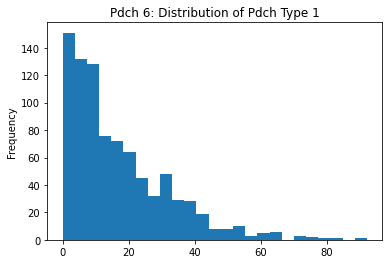

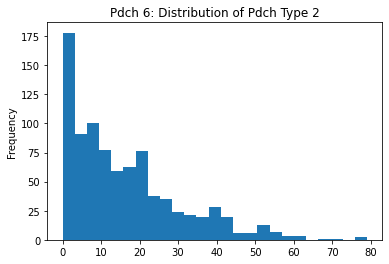

In [2]:
#Assign variables                                 
num_neurons = 872        #number of neurons
num_pdch = 100          #total number of Pdch per neuron
types = 6

#Create matrix of zeros
#Each vector in the matrix will hold information on a neuron.
#Each value in the vector will represent how much of a specific Pdch there is in that neurons
#Ex, [20, 30, 50] --> 20 Pdch of type 1, 30 Pdch of type 2, 50 Pdch of type 3
matrix = np.zeros((num_neurons, types))          

#Assign random combination of Pdch amounts to a neuron so total pdch adds up to 100. 
def random_assigment(n, total):                                  #n = how many pdch types, #total = total pdch amount
    dividers = sorted(random.sample(range(1, total), n-1))
    return [a - b for a, b in zip(dividers + [total], [0] + dividers)]

def random_assigment2(n, total):

    return [x - 1 for x in random_assigment(n, total + n)]

      
#Assign random pdch amounts for each neurons
x = -1
for i in range(num_neurons):                                   
    x = x + 1
    y = -1
    random_vector = random_assigment2(types, num_pdch) 
    for j in range(types):
        y = y + 1      
        matrix[x][y] = random_vector[y]



plt.hist(matrix[:, [0]], bins = 25)
plt.gca().set(title="Pdch %i: Distribution of Pdch Type 1" %types, ylabel='Frequency');
plt.show()

plt.hist(matrix[:, [1]], bins = 25)
plt.gca().set(title="Pdch %i: Distribution of Pdch Type 2"%types, ylabel='Frequency');
plt.show()

#Normalize vector
matrix = matrix/np.sum(matrix)

**Calculating Similarity between Neurons**

In [3]:
input_layer = np.arange(0,784)    #Separate all the neurons in the matrix with Pdch information into their layers
inner_layer = np.arange(784, 862)
output_layer = np.arange(862, 872)

#Create Ecludian distance matrix between neurons in input and inner layer
distance_in = np.zeros((78, 784))       #78 neurons in inner layer and 784 in input

a = -1
for i in range(78):
    a = a + 1
    b = -1
    for j in range(784):
        b = b + 1
        Ecl_distance = norm(matrix[input_layer[b]]- matrix[inner_layer[a]]) #Calculate ecludian distance
        distance_in[a][b] =  Ecl_distance

#Create Ecludian distance matrix between neurons in inner layer and output layer
distance_out = np.zeros((10, 78))       #78 neurons in inner layer and 10 in ouput

c = -1
for i in range(10):
    c = c + 1
    d = -1
    for j in range(78):
        d = d + 1
        Ecl_distance = norm(matrix[inner_layer[d]]- matrix[output_layer[c]]) #Ecludian distance
        distance_out[c][d] = Ecl_distance

In [4]:
#Define functions that will calculate max, second max and min of two matrices
#Needed to normalize matrices later on

def limit_calc(vector_1, vector_2):
    unique_vec1 = np.unique(vector_1)
    unique_vec2 = np.unique(vector_2)
    
    #Find max value of matrices
    max1 = max(unique_vec1)
    max2 = max(unique_vec2)

    #Find second max value of matrices
    max1_2 = max(unique_vec1[unique_vec1 != max1])
    max2_2 = max(unique_vec2[unique_vec2 != max2])

    #determine the highest and second highest maximum of the two matrices combined
    if max1 > max2:                    
        maxvalue = max1
        if max1_2 >= max2:              
            secondmax = max1_2
        else: 
            secondmax = max2
    if max1 < max2:
        maxvalue = max2
        if max2_2 >= max1:
            secondmax = max2_2
        else: 
            secondmax = max1
    else: 
        maxvalue = max1
        if max2_2 >= max1_2:
            secondmax = max2_2
        else: 
            secondmax = max1_2
    
    min1 = min(unique_vec1)
    min2 = min(unique_vec2)
    #deterine min of two matrices
    if min1 >= min2:                    
        minvalue = min2
    else: 
        minvalue = min1 
    
    min1_2 = min(unique_vec1[unique_vec1 != min1])
    min2_2 = min(unique_vec2[unique_vec2 != min2])

    #determine the second min the two matrices combined
    if min1_2 >= min2_2:                    
        minvalue_2 = min2_2
    else: 
        minvalue_2 = min1_2 

    return maxvalue, secondmax, minvalue, minvalue_2


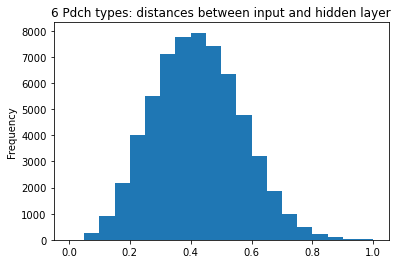

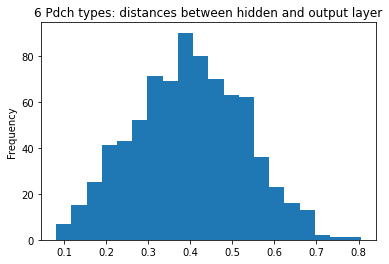

In [5]:
norm = limit_calc(distance_in, distance_out)
norm_max = norm[0]
norm_min = norm[2]

#Normalize between 0-1
distance_input = (distance_in - norm_min)/(norm_max - norm_min)
distance_output = (distance_out - norm_min)/(norm_max - norm_min)

#plot distribution of two matrices 
plt.hist(distance_input.flatten(), bins=20)
plt.gca().set(title='%i Pdch types: distances between input and hidden layer'%types, ylabel='Frequency');
plt.show()

plt.hist(distance_output.flatten(), bins=20)
plt.gca().set(title='%i Pdch types: distances between hidden and output layer'%types, ylabel='Frequency');
plt.show()

**Function that Assigns Weights**

In [6]:
#Create weight matrix between neurons in input and inner layer
def weight_matrix(model, vector_in, vector_out, skewness, location, location_change, shape):

    weight_in = np.zeros((78, 784))       

    a = -1
    for i in range(78):
        a = a + 1
        b = -1
        for j in range(784):
            b = b + 1
            weight = skewnorm.pdf(vector_in[a][b], skewness, location + location_change, shape) #weight at specific distance based on the skwewed normal distribution
            weight_in[a][b] =  weight

    #Create Ecludian distance matrix between neurons in inner layer and output layer
    weight_out = np.zeros((10, 78))      

    c = -1
    for i in range(10):
        c = c + 1
        d = -1
        for j in range(78):
            d = d + 1
            weight = skewnorm.pdf(vector_out[c][d], skewness, location + location_change, shape) #weight at specific distance based on the skwewed normal distribution
            weight_out[c][d] =  weight
            
    if model == 1:
        zero = skewnorm.pdf(1.0, skewness, location + location_change, shape)
    else: 
        zero = skewnorm.pdf(0.0, skewness, location + location_change, shape)
    
    #for all values below weight at max distance value/most disimillar assign a weight of zero
    a = -1
    for i in range(78):
        a = a + 1
        b = -1
        for j in range(784):
            b = b + 1
            if weight_in[a][b] <= zero:
                weight_in[a][b] =  0

    c = -1
    for i in range(10):
        c = c + 1
        d = -1
        for j in range(78):
            d = d + 1
            if weight_out[c][d] <= zero:
                weight_out[c][d] =  0

    #normalize between 0 to 1
    normal = limit_calc(weight_in, weight_out)
    normalmax = normal[0]
    normalmin = normal[2]
    weight_input = (weight_in - normalmin)/(normalmax-normalmin)
    weight_output = (weight_out - normalmin)/(normalmax-normalmin)
    
    #Randomly assign + and - values to weights (So exactly half has -)
    for i in range(61152):
        x = np.random.randint(0,78)
        y = np.random.randint(0,784)
        weight_input[x, y] = weight_input[x , y]* -1

    for i in range(780):
        x = np.random.randint(0,10)
        y = np.random.randint(0,78)
        weight_output[x, y] = weight_output[x , y]* -1
        
    #plot distribution of two matrices 
    plt.hist(weight_input.flatten(), bins=30)
    plt.gca().set(title='Model %i:Histogram for Weights in Input Layer'%model, ylabel='Frequency');
    plt.show()

    plt.hist(weight_output.flatten(), bins=30)
    plt.gca().set(title='Model %i:Histogram for Weights in Hidden Layer'%model, ylabel='Frequency');
    plt.show()
    
    #Save weight matrix into txt file
    np.savetxt('model%iweightin_%i.txt'%(model, types), weight_input, delimiter = ',')  
    np.savetxt('model%iweightout_%i.txt'%(model, types), weight_output, delimiter = ',')  

**Assigning Weights based on Model 1**

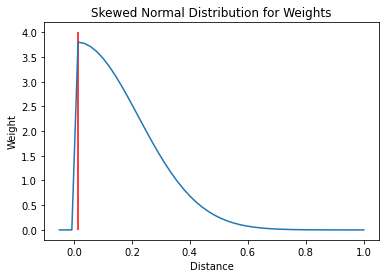

0.0 3.79927798277394 5.8610284674950384e-05


In [7]:
callibrate = limit_calc(distance_input, distance_output)
secondmax = callibrate[1]
secondmin = callibrate[3]

model = 1
skewness= 1000
location= secondmin
location_change= -0.002
shape = 0.21

X = np.linspace(-0.05, 1.0)    #range of distances/x-axis
plt.plot(X, skewnorm.pdf(X, skewness, location + location_change, shape))  #plot the skewed normal 
plt.vlines(secondmin, 0, 4, color = 'red')
plt.gca().set(title='Skewed Normal Distribution for Weights', xlabel = 'Distance', ylabel='Weight'); 
plt.show()

#weights at specific distances based on the skwewed normal distribution
y = skewnorm.pdf(0.0, skewness, location + location_change, shape)
y1 = skewnorm.pdf(secondmin, skewness, location + location_change, shape)
y2 = skewnorm.pdf(1.0, skewness, location + location_change, shape)
print(y, y1, y2)

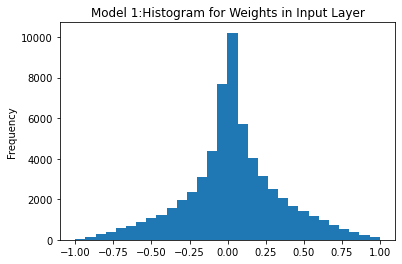

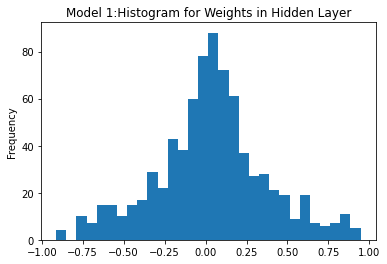

In [8]:
weight_matrix(model, distance_input, distance_output, skewness, location, location_change, shape)

**Assigning Weights based on Model 2**

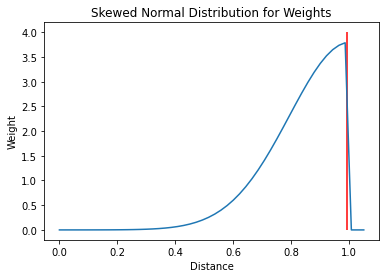

4.2386048237792616e-05 3.792832437516719 3.7990899520112005


In [9]:
model = 2
skewness= -1000
location= secondmax
location_change= +0.0124
shape = 0.21

X = np.linspace(0, 1.05)    #range of distances/x-axis
plt.plot(X, skewnorm.pdf(X, skewness, location + location_change, shape))  #plot the skewed normal 
plt.vlines(secondmax, 0, 4, color = 'red')
plt.gca().set(title='Skewed Normal Distribution for Weights', xlabel = 'Distance', ylabel='Weight'); 
plt.show()

#weights at specific distances based on the skwewed normal distribution
y = skewnorm.pdf(0.0,  skewness, location + location_change, shape)
y1 = skewnorm.pdf(secondmax,  skewness, location + location_change, shape)
y2 = skewnorm.pdf(1.0, skewness, location + location_change, shape)
print(y, y1, y2)

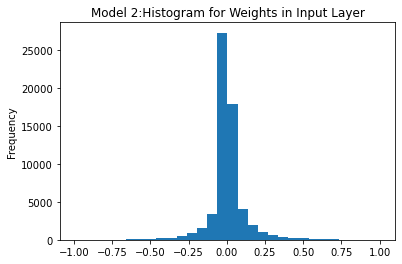

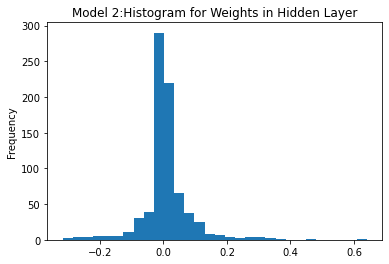

In [10]:
weight_matrix(model, distance_input, distance_output, skewness, location, location_change, shape)